# <font color="chillipepper">Introduction au deep learning</font>

Nous utiliserons le corpus pour ce TD `imdb`.

## Description
Le jeu de donn√©es IMDb disponible via `load_dataset('imdb')` de la biblioth√®que Hugging Face Datasets contient des critiques de films provenant d'IMDb.

## Contenu
- **Nombre total de critiques** : 50 000
  - **Entra√Ænement** : 25 000 critiques
  - **Test** : 25 000 critiques

## √âtiquettes
- Chaque critique est √©tiquet√©e comme :
  - **Positive**
  - **N√©gative**

## Format
- Les critiques sont fournies sous forme de texte brut.

Nous allons entrainer et comparer 2 mod√®les de classification de texte en utilisant 2 m√©thodes diff√©rentes.

In [ ]:
#!pip install datasets
#!pip install torchinfo

## librairies

In [ ]:
import torch
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="dark")

## Donn√©es

In [ ]:
data = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
data.set_format(type="pandas")
df = data["train"][:]
df.head()

text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0

In [ ]:
test_df = data["test"][:]
test_df.head()

text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average film with a few semi-alr...      0
3  STAR RATING: ***** Saturday Night **** Friday ...      0
4  First off let me say, If you haven't enjoyed a...      0

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index)
plt.ylabel("Nb comments")
plt.show()

Nous avons autant de commentaires positifs que n√©gatifs.

In [ ]:
# Calcul du nombre de mots par commentaire
df["Words Per comment"] = df["text"].str.split().apply(len)

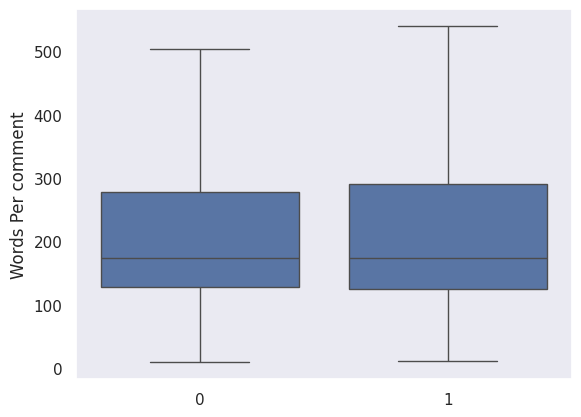

In [ ]:
sns.boxplot(data=df, x="label", y="Words Per comment", showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

Les commentaires ont autour de 180 mots pour chaque type de sentiment. Les plus longs ne pourront pas √™tre pris en compte par le tokenizer car √©tant sup√©rieurs √† la longueur maximale accept√©e. Il seront donc coup√©s.

In [ ]:
data.reset_format()

## Tokenizer

In [ ]:
BATCH_SIZE = 16

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer(["Bonjour, comment vas-tu ?"], )

{'input_ids': [[101, 14753, 23099, 2099, 1010, 7615, 12436, 2015, 1011, 10722, 1029, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

## DataHandler

Let's create a datahandler.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
data['train'][1]["text"]

'"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the s

In [ ]:
class IMDbDataset(Dataset):
    def __init__(self,data, tokenizer, max_length: int=512):
        self.dataset = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Permet de faire des paquets de donn√©es et de les rendre sous un format it√©rable
def create_data_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_dataset = IMDbDataset(data['train'], tokenizer)
test_dataset = IMDbDataset(data['test'], tokenizer)

In [ ]:
train_dataset[0]

{'input_ids': tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
          2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
          2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
          2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
          1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
          2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000,
          6801,  1000,  1045,  2428,  2018,  2000,  2156,  2023,  2005,  2870,
          1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,  1996,
          5436,  2003,  8857,  2105,  1037,  2402,  4467,  3689,  3076,  2315,
         14229,  2040,  4122,  2000,  4553,  2673,  2016,  2064,  2055,  2166,
          1012,  1999,  3327,  2016,  4122,  2000,  3579,  2014,  3086,  2015,
          2000,  2437,  2070,  4066,  1997,  4516,  2006,  2054,  1996,  2779,
         25430, 14728,  2245,  2055,  3

In [ ]:
train_data_loader = create_data_loader(train_dataset, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset, BATCH_SIZE)

## <font color="chillipepper">Mod√®le Pytorch </font>

Notre objectif est de d√©finir un mod√®le d'apprentissage profond, de l'entra√Æner, de faire des pr√©dictions avec et de l'√©valuer.

Avec PyTorch, cela signifie faire les trois "scripts" suivants :

1. **D√©finir le mod√®le**
2. **Impl√©menter la pr√©diction**
3. **Impl√©menter la boucle d'entra√Ænement**
    - D√©finir une fonction de perte
    - D√©finir un optimiseur
    - Boucle :
        - Passage avant (forward pass)
        - Passage arri√®re (backward pass)
        - Appliquer la r√®gle de mise √† jour de l'optimisation
4. **√âvaluer le mod√®le / jouer avec**
    - Vous pouvez utiliser le crit√®re d'entra√Ænement (perte) comme score d'√©valuation
    - Vous pouvez utiliser un autre score : pr√©cision (accuracy), F1

### <font color="chillipepper">1. Definissons le mod√®le</font>

Les mod√®les PyTorch suivent toujours le m√™me mod√®le :

- une classe
- d√©finition de toutes les couches (ou param√®tres) dans `__init__()`
- d√©finition du passage avant dans `forward()`

Voyons √† quoi cela ressemble avec un mod√®le simple √† 2 couches.

Toutes les couches triviales de r√©seaux neuronaux peuvent g√©n√©ralement √™tre trouv√©es dans torch.nn.

**Attention** : Tous vos modules param√©tr√©s (couches ou vecteurs entra√Ænables) doivent √™tre d√©finis comme des attributs *directs* de votre classe ```nn.Module``` afin que l'appel √† ```.backward()``` puisse correctement propager les gradients √† travers tout. Pour d√©finir des couches dans un attribut de liste (resp. attributs de dictionnaire), utilisez ```ModuleList``` (resp. ```ModuleDict```).

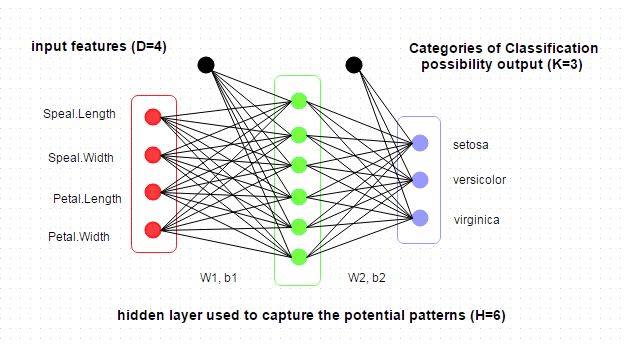


In [ ]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import torch.nn as nn
from torchinfo import summary

In [ ]:


class MinimalExampleModel(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        Dans le constructeur, nous instancions deux modules nn.Linear et les assignons
        comme variables membres.
        """
        super(MinimalExampleModel, self).__init__()
        # d√©finir une premi√®re couche lin√©aire avec une dimension d'entr√©e (D_in) et une dimension cach√©e (H)
        # documentation de la couche lin√©aire : https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        self.linear1 = nn.Linear(D_in, H, bias=True)
        # d√©finir la couche lin√©aire finale, souvent appel√©e couche de classification car la dimension de sortie (D_out) == le nombre de classes cibles
        self.linear2 = nn.Linear(H, D_out, bias=True)

    def forward(self, x):
        """
        Dans la fonction forward, nous acceptons un tenseur de donn√©es d'entr√©e et nous devons retourner
        un tenseur de donn√©es de sortie. Nous pouvons utiliser les modules d√©finis dans le constructeur ainsi que des op√©rateurs arbitraires sur les tenseurs.
        """
        # appliquer d'abord la couche linear1 sur le vecteur et l'encapsuler avec une fonction d'activation pour la non-lin√©arisation. Cela cr√©e une couche dense.
        # documentation de relu : https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        h_relu = torch.relu(self.linear1(x))
        y_pred = self.linear2(h_relu)
        return y_pred

### <font color="chillipepper">2. Forward pass</font>
1. Initialiser le mod√®le
2. mettre des donn√©es en entr√©e
3. calculer la foward pass

In [ ]:
# instanciating the model with
# N:      batch size
# D_in:   input dimension
# H:      hidden dimension
# D_out:  output dimension
N, D_in, H, D_out = 2, 10, 10, 2


# Note: tous les param√®tres sont initialis√©s ici
model = MinimalExampleModel(D_in, H, D_out)
# visualisons le contenu
model

MinimalExampleModel(
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
# utilisons torch infos pour mieux comprendre le contenu du mod√®le: https://github.com/TylerYep/torchinfo

dummy_input_size = (1, 10) # (batch_size, D_in)
summary(model, (N, D_in))

Layer (type:depth-idx)                   Output Shape              Param #
MinimalExampleModel                      [2, 2]                    --
‚îú‚îÄLinear: 1-1                            [2, 10]                   110
‚îú‚îÄLinear: 1-2                            [2, 2]                    22
Total params: 132
Trainable params: 132
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
# Avant de passer √† l'entrainement, faisons un test rapide de notre mod√®le
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# v√©rifier si un acc√©lerateur est disponible
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
model = model.to(device)

#model = MyModel(D_in, H, D_out)
# forward pass / predict x
y_pred = model(x.to(device)) # almost equivalent to model.forward(x)
# y_pred
y_pred

DEVICE =  CPU


tensor([[ 0.3060, -0.0449],
        [ 0.1256,  0.2465]], grad_fn=<AddmmBackward0>)

### <font color="chillipepper">3. Notre premier mod√®le de classification</font>

In [ ]:
class TweetModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, output_dim, embed_dim):
        """
        Dans le constructeur, nous instancions deux modules nn.Linear et les assignons
        comme variables membres.
        """
        super(TweetModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.hidden_linear_layer = nn.Linear(embed_dim, hidden_dim, bias=True)
        self.classification_layer = nn.Linear(hidden_dim, output_dim, bias=True)
        # couche softmax pour calculer les probabilit√©s des classes
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Dans la fonction forward, nous acceptons un tenseur de donn√©es d'entr√©e et nous devons retourner
        un tenseur de donn√©es de sortie. Nous pouvons utiliser les modules d√©finis dans le constructeur ainsi que des op√©rateurs arbitraires sur les tenseurs.
        """
        # appliquer les embeddings pr√©-entra√Æn√©s
        x = self.embedding(x)
        x = x.mean(1)
        h = torch.relu(self.hidden_linear_layer(x))
        h = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [ ]:
vocab_size = tokenizer.vocab_size
embed_dim = 128
hidden_dim = 128
output_dim = 2
lr = 2e-5
n_epoch = 5

model = TweetModel(vocab_size, embed_dim, hidden_dim, output_dim)

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=lr)
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
loss_fn = CrossEntropyLoss()


### <font color="chillipepper">4. Boucle d'entra√Ænement </font>

- **Crit√®re** :

Un mod√®le est entra√Æn√© par rapport √† un _crit√®re d'entra√Ænement_ ou une _perte_.   
PyTorch fournit de nombreuses pertes pr√©-cod√©es diff√©rentes :
    - Erreur quadratique moyenne (Mean-Square Error)
    - Entropie crois√©e cat√©gorielle (Categorical Cross-Entropy), ...

La plupart d'entre elles peuvent √™tre trouv√©es dans torch.nn.

- **Optimiseur** :

Dans PyTorch, comme dans tout framework d'apprentissage profond (par exemple TensorFlow), les mod√®les sont entra√Æn√©s avec la r√©tropropagation. La r√©tropropagation consiste √† appliquer la descente de gradient stochastique (SGD) √† un r√©seau de neurones. Il existe une large gamme de variantes autour de la forme simple de la SGD.

PyTorch fournit des objets pr√©d√©finis pour de nombreuses formes diff√©rentes d'algorithmes de descente de gradient dans torch.optim :
- SGD
- Adadelta
- Adam

Dans ce notebook, nous utilisons ce dernier, en raison de sa convergence g√©n√©ralement plus rapide.

Votre optimiseur sera instanci√© avec sa configuration (par exemple, le *step_size* ou *learning_rate* pour SGD), et les param√®tres du r√©seau.

Aper√ßu de tous les algorithmes bas√©s sur la descente de gradient : https://ruder.io/optimizing-gradient-descent/

- **Boucle d'entra√Ænement** :
    - Passage avant (forward pass) pour obtenir la pr√©diction et la valeur de la perte
    - `zero_grad` : R√©initialiser la valeur du gradient √† z√©ro pour tous les param√®tres avant d'ajouter leurs nouvelles valeurs r√©tropropag√©es (cette √©tape est cruciale !)
    - Calculer la valeur des gradients avec `loss.backward()`
    - Mettre √† jour tous les param√®tres du mod√®le avec `optimizer.step()`

L'ordre de ces √©tapes ne doit **PAS** √™tre modifi√© !

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device) # Le mod√®le et les donn√©es doivent √™tre au m√™me acc√©lerateur
        attention_mask = d['attention_mask'].to(device)
        labels = d['label'].to(device)

        outputs = model(input_ids)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
for epoch in range(n_epoch):
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        len(train_dataset)
    )
    print(f'Epoch {epoch + 1}/{n_epoch}')
    print(f'Train loss {train_loss} accuracy {train_acc}')

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1563/1563 [01:02<00:00, 25.03it/s]


Epoch 1/5
Train loss 4.82103646815929 accuracy 0.41016


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1563/1563 [01:00<00:00, 25.85it/s]


Epoch 2/5
Train loss 4.53238438980288 accuracy 0.49976


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1563/1563 [00:59<00:00, 26.17it/s]


Epoch 3/5
Train loss 4.394180465644548 accuracy 0.49988


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1563/1563 [00:58<00:00, 26.78it/s]


Epoch 4/5
Train loss 4.373527189744106 accuracy 0.50004


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1563/1563 [00:58<00:00, 26.79it/s]

Epoch 5/5
Train loss 4.367134138474614 accuracy 0.50004


### <font color="chillipepper">4. Evaluation du mod√®le </font>

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['label'].to(device)

            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return accuracy_score(real_values, predictions)

In [ ]:
test_accuracy = evaluate_model(model, test_data_loader, device)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.49996


### <font color="chillipepper">5. Am√©liorons les r√©sultats </font>

Un mod√®le al√©aatoire fait mieux que le mod√®le pr√©c√©dent. Nous allons utiliser un mod√®le pr√©-entrainer pour am√©liorer ces r√©sultats.

Pour ce faire, nous allons utiliser les classes de huggingface pour effectuer l'entrainement.

In [ ]:
from transformers import AutoModelForSequenceClassification
# Initialisation du mod√®le
num_labels = 2
model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Tokenize the dataset
tokenized_dataset = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset["train"].column_names)


['text', 'label', 'input_ids', 'attention_mask']


In [ ]:

from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-imdb"
training_args = TrainingArguments(
                                  output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error",
                                  save_strategy="no",
                                report_to="none")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset["train"],
                  eval_dataset=tokenized_dataset["test"],
                  tokenizer=tokenizer,
                  )

<ipython-input-41-9acbcfa20f0c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [ ]:
trainer.train();

In [ ]:
preds_output = trainer.predict(tokenized_dataset["test"])

preds_output.metrics